# IBM Data Science Capstone: The Battle of Neighborhoods

**Table of Contents**
1. Introduction
2. Data
3. Methodology
4. Result
5. Discussion, Conclusion

## Introduction
Embarking on a new restaurant venture is a challenging process, frought with financial risk and uncertainty, and can only benefit from the careful analysis of any and all available data. In this instance, the goal of the data analysis is to find a suitable place to open a fine dining restaurant within the city of London.

This data is conceived as though it would be provided to a sole proprietor from a market research firm hired to analyze various datapoints that might prove useful in making a final location decision.

## Data
This project will collect data from Wikipedia and Foursquare.

For the sake of simplicity, all London-designated postcodes will be included in the analysis. Data will be gathered from <https://en.wikipedia.org/wiki/List_of_areas_of_London >

In [1]:
from bs4 import BeautifulSoup
# library to handle data in a vectorized manner
import numpy as np

# library for data analsysis
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# library to handle JSON files
import json
print('numpy, pandas, ..., imported...')

!pip -q install geopy
# conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
print('geopy installed...')
# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim
print('Nominatim imported...')

import requests
print('requests imported...')

from pandas.io.json import json_normalize
print('json_normalize imported...')

import matplotlib.cm as cm
import matplotlib.colors as colors
print('matplotlib imported...')

from sklearn.cluster import KMeans
print('Kmeans imported...')

!pip -q install geocoder
import geocoder
import time

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip -q install folium
import folium
print('...Done')

numpy, pandas, ..., imported...
geopy installed...
Nominatim imported...
requests imported...
json_normalize imported...
matplotlib imported...
Kmeans imported...
...Done


In [2]:
wikipedia_link = 'https://en.wikipedia.org/wiki/List_of_areas_of_London'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:64.0) Gecko/20100101 Firefox/64.0'}
wikipedia_page = requests.get(wikipedia_link, headers = headers)
wikipedia_page

<Response [200]>

In [3]:
soup = BeautifulSoup(wikipedia_page.content, 'html.parser')
table = soup.find('table', {'class':'wikitable sortable'}).tbody

In [4]:
rows = table.find_all('tr')

In [5]:
columns = [i.text.replace('\n', '')
           for i in rows[0].find_all('th')]

In [6]:
df = pd.DataFrame(columns = columns)
df

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref


In [7]:
for i in range(1, len(rows)):
    tds = rows[i].find_all('td')
    
    
    if len(tds) == 7:
        values = [tds[0].text, tds[1].text, tds[2].text.replace('\n', ''.replace('\xa0','')), tds[3].text, tds[4].text.replace('\n', ''.replace('\xa0','')), tds[5].text.replace('\n', ''.replace('\xa0','')), tds[6].text.replace('\n', ''.replace('\xa0',''))]
    else:
        values = [td.text.replace('\n', '').replace('\xa0','') for td in tds]
        
        df = df.append(pd.Series(values, index = columns), ignore_index = True)

        df

In [8]:
df.head(5)

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [9]:
df = df.rename(index=str, columns = {'Location': 'Location', 'London\xa0borough': 'Borough', 'Post town': 'Post-town', 'Postcode\xa0district': 'Postcode', 'Dial\xa0code': 'Dial-code', 'OS grid ref': 'OSGridRef'})

In [10]:
df.head(5)

,Location,Borough,Post-town,Postcode,Dial-code,OSGridRef
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


Artifacts from Wikipedia's referencing system can be seen (the brackets[ ]), and will be removed.

In [11]:
df['Borough'] = df['Borough'].map(lambda x: x.rstrip(']').rstrip('0123456789').rstrip('['))

In [12]:
df.shape

(533, 6)

In [13]:
df.head(5)

,Location,Borough,Post-town,Postcode,Dial-code,OSGridRef
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon,CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


Call restrictions to Foursquare's API force this project to limit scope to a subset of the city of London.

### Limiter 1. 
If more than 1 postcode (ex. Acton), the Borough will be duplicated, and each unique postcode will be applied to an independent row.

In [15]:
df0 = df.drop('Postcode', axis=1).join(df['Postcode'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('Postcode'))

In [16]:
df0.head(5)

,Location,Borough,Post-town,Dial-code,OSGridRef,Postcode
0,Abbey Wood,"Bexley, Greenwich",LONDON,020,TQ465785,SE2
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,020,TQ205805,W3
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,020,TQ205805,W4
10,Angel,Islington,LONDON,020,TQ345665,EC1
10,Angel,Islington,LONDON,020,TQ345665,N1


This resulted in Acton occupying 2 rows, each with a unique postcode

### Limiter 2. 
The breadth of data is too large, and only a subset is required.

In [17]:
df1 = df0[['Location', 'Borough', 'Postcode', 'Post-town']].reset_index(drop=True)

In [18]:
df1.head(5)

,Location,Borough,Postcode,Post-town
0,Abbey Wood,"Bexley, Greenwich",SE2,LONDON
1,Acton,"Ealing, Hammersmith and Fulham",W3,LONDON
2,Acton,"Ealing, Hammersmith and Fulham",W4,LONDON
3,Angel,Islington,EC1,LONDON
4,Angel,Islington,N1,LONDON


In [19]:
df1.shape

(637, 4)

### Limiter 3.
Only postcodes corresponding to "LONDON" as Post-town will be used - all else will be dropped.

In [20]:
df2 = df1
df21 = df2[df2['Post-town'].str.contains('LONDON')]

In [21]:
df21.head(5)

,Location,Borough,Postcode,Post-town
0,Abbey Wood,"Bexley, Greenwich",SE2,LONDON
1,Acton,"Ealing, Hammersmith and Fulham",W3,LONDON
2,Acton,"Ealing, Hammersmith and Fulham",W4,LONDON
3,Angel,Islington,EC1,LONDON
4,Angel,Islington,N1,LONDON


In [22]:
df21.shape

(381, 4)

Many less instances thanks to this limiter.

In [23]:
df3 = df21[['Location', 'Borough', 'Postcode']].reset_index(drop=True)

In [24]:
df3.head(10)

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Angel,Islington,EC1
4,Angel,Islington,N1
5,Church End,Brent,NW10
6,Church End,Barnet,N3
7,Clapham,"Lambeth, Wandsworth",SW4
8,Clerkenwell,Islington,EC1
9,Colindale,Barnet,NW9


In [25]:
df_london = df3
df_london.to_csv('LondonLocations.csv', index = False)

### Limiter 4.
Let's assume our future restauranteur client has a house in Southeast London, and would like to avoid lengthy tube rides to and from work. This can help us limit the search (and limit Foursquare calls)

To achieve this, we will drop all non-SE postcodes

In [26]:
df_london.head(5)

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Angel,Islington,EC1
4,Angel,Islington,N1


In [27]:
df_london.Postcode = df_london.Postcode.str.strip()

In [28]:
df_london.head(5)

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Angel,Islington,EC1
4,Angel,Islington,N1


Create a new data-frame for our SE subset

In [29]:
df_se = df_london[df_london['Postcode'].str.startswith(('SE'))].reset_index(drop=True)

In [30]:
df_se.head(10)

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Crofton Park,Lewisham,SE4
2,Crossness,Bexley,SE2
3,Crystal Palace,Bromley,SE19
4,Crystal Palace,Bromley,SE20
5,Crystal Palace,Bromley,SE26
6,Denmark Hill,Southwark,SE5
7,Deptford,Lewisham,SE8
8,Dulwich,Southwark,SE21
9,East Dulwich,Southwark,SE22


In [32]:
demograph_link = 'https://en.wikipedia.org/wiki/Demography_of_London'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:64.0) Gecko/20100101 Firefox/64.0'}
demograph_page = requests.get(demograph_link, headers = headers)
soup1 = BeautifulSoup(demograph_page.content, 'html.parser')
table1 = soup1.find('table', {'class':'wikitable sortable'}).tbody
rows1 = table1.find_all('tr')
columns1 = [i.text.replace('\n', '')
           for i in rows1[0].find_all('th')]

In [33]:
columns1

['Local authority', 'White', 'Mixed', 'Asian', 'Black', 'Other']

In [34]:
demo_london = pd.DataFrame(columns = columns1)

In [36]:
demo_london.head(5)

,Local authority,White,Mixed,Asian,Black,Other


In [37]:
for j in range(1, len(rows1)):
    tds1 = rows1[j].find_all('td')
    if len(tds1) == 7:
        values1 = [tds1[0].text, tds1[1].text, tds1[2].text.replace('\n', ''.replace('\xa0','')), tds1[3].text, tds1[4].text.replace('\n', ''.replace('\xa0','')), tds1[5].text.replace('\n', ''.replace('\xa0',''))]
    else:
        values1 = [td1.text.replace('\n', '').replace('\xa0','') for td1 in tds1]
        
        demo_london = demo_london.append(pd.Series(values1, index = columns1), ignore_index = True)

        demo_london

In [38]:
demo_london['Black'] = demo_london['Black'].astype('float')

In [39]:
demo_london_sorted = demo_london.sort_values(by='Black', ascending = False)

In [40]:
demo_london_sorted.head(5)

,Local authority,White,Mixed,Asian,Black,Other
22,Lewisham,53.5,7.4,9.3,27.2,2.6
27,Southwark,54.3,6.2,9.4,26.9,3.3
21,Lambeth,57.1,7.6,6.9,25.9,2.4
11,Hackney,54.7,6.4,10.5,23.1,5.3
7,Croydon,55.1,6.6,16.4,20.2,1.8


As the client sole proprietor is unsure of the specifics of the food he wishes to focus on, I will draw in on an area of high diversity within the city, to hopefully create a more broadly-varied range of tastes as foot-traffic for the business

In [41]:
df_se

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Crofton Park,Lewisham,SE4
2,Crossness,Bexley,SE2
3,Crystal Palace,Bromley,SE19
4,Crystal Palace,Bromley,SE20
5,Crystal Palace,Bromley,SE26
6,Denmark Hill,Southwark,SE5
7,Deptford,Lewisham,SE8
8,Dulwich,Southwark,SE21
9,East Dulwich,Southwark,SE22


In [43]:
df_se_top = df_se[df_se['Borough'].isin(['Lewisham', 'Southwark', 'Lambeth', 'Hackney', 'Croydon'])].reset_index(drop=True)

In [44]:
df_se_top.head(5)

,Location,Borough,Postcode
0,Crofton Park,Lewisham,SE4
1,Denmark Hill,Southwark,SE5
2,Deptford,Lewisham,SE8
3,Dulwich,Southwark,SE21
4,East Dulwich,Southwark,SE22


In [45]:
df_se_top.shape

(46, 3)

In [47]:
df_se.shape

(80, 3)

### Combining location data with geographical data

In [48]:
# using Geocoder to get latitude and longitude
def get_latlng(arcgis_geocoder):
    
    # Initialize the Location (lat. and long.) to "None"
    lat_lng_coords = None
    
    # While loop helps to create a continous run until all the location coordinates are geocoded
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, London, United Kingdom'.format(arcgis_geocoder))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [49]:
start = time.time()

postal_codes = df_se_top['Postcode']    
coordinates = [get_latlng(postal_code) for postal_code in postal_codes.tolist()]

end = time.time()
print("Time of execution: ", end - start, "seconds")

Time of execution:  27.28743863105774 seconds


Store and join geographic data to previous dataframe

In [51]:
df_se_loc = df_se_top

df_se_coordinates = pd.DataFrame(coordinates, columns = ['Latitude', 'Longitude'])
df_se_loc['Latitude'] = df_se_coordinates['Latitude']
df_se_loc['Longitude'] = df_se_coordinates['Longitude']

In [52]:
df_se_loc.head(5)

,Location,Borough,Postcode,Latitude,Longitude
0,Crofton Park,Lewisham,SE4,51.46268,-0.03558
1,Denmark Hill,Southwark,SE5,51.47480,-0.09313
2,Deptford,Lewisham,SE8,51.48114,-0.02467
3,Dulwich,Southwark,SE21,51.44100,-0.08897
4,East Dulwich,Southwark,SE22,51.45256,-0.07076


In [53]:
df_se_loc.to_csv('SELondonLocationsCoordinates.csv', index = False)

In [54]:
df_se_loc.shape

(46, 5)

### Foursquare joins geographical data
Using Foursquare, location data will be gathered on the SE London area, as will proximity to amenities, destinations, etc. (drivers of foot traffic)

In [57]:
CLIENT_ID = 'QEF4SFROUUVOQKNPAFNNRDUW4ACAWSYYG312LM3BKEDDKPIZ'
CLIENT_SECRET = 'CCBFW1WDVTUYDLPFX3SR0QBB5R2UKRYOZ3F1JDJ3PLQMPDRM'
VERSION = '20180604'

## Methodology

In [58]:
se_df = df_se_loc.reset_index().drop('index', axis = 1)

In [60]:
se_df.shape

(46, 5)

In [61]:
se_df

,Location,Borough,Postcode,Latitude,Longitude
0,Crofton Park,Lewisham,SE4,51.46268,-0.03558
1,Denmark Hill,Southwark,SE5,51.47480,-0.09313
2,Deptford,Lewisham,SE8,51.48114,-0.02467
3,Dulwich,Southwark,SE21,51.44100,-0.08897
4,East Dulwich,Southwark,SE22,51.45256,-0.07076
5,Elephant and Castle,Southwark,SE1,51.49996,-0.09568
6,Elephant and Castle,Southwark,SE11,51.49084,-0.11108
7,Elephant and Castle,Southwark,SE17,51.48764,-0.09542
8,Bankside,Southwark,SE1,51.49996,-0.09568
9,Forest Hill,Lewisham,SE23,51.44122,-0.04764


In [62]:
se_df.loc[se_df['Location'] == 'Lewisham']

,Location,Borough,Postcode,Latitude,Longitude
20,Lewisham,Lewisham,SE13,51.46196,-0.00754


In [63]:
se_df.loc[20, 'Location']

'Lewisham'

In [64]:
lewisham_lat = se_df.loc[20, 'Latitude']
lewisham_long = se_df.loc[20, 'Longitude']
lewisham_loc = se_df.loc[20, 'Location']
lewisham_postcode = se_df.loc[20, 'Postcode']

print('The latitude and longitude values of {} with postcode {}, are {}, {}.'.format(lewisham_loc,
                                                                                         lewisham_postcode,
                                                                                         lewisham_lat,
                                                                                         lewisham_long))

The latitude and longitude values of Lewisham with postcode SE13, are 51.46196000000003, -0.007539999999949032.


In [65]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 2000 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lewisham_lat, 
    lewisham_long, 
    radius, 
    LIMIT)

url

'https://api.foursquare.com/v2/venues/explore?&client_id=QEF4SFROUUVOQKNPAFNNRDUW4ACAWSYYG312LM3BKEDDKPIZ&client_secret=CCBFW1WDVTUYDLPFX3SR0QBB5R2UKRYOZ3F1JDJ3PLQMPDRM&v=20180604&ll=51.46196000000003,-0.007539999999949032&radius=2000&limit=100'

In [66]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e9d3fa4882fc7002038ab4c'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Lewisham Central',
  'headerFullLocation': 'Lewisham Central, London',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 188,
  'suggestedBounds': {'ne': {'lat': 51.47996001800005,
    'lng': 0.021296961190459426},
   'sw': {'lat': 51.44395998200002, 'lng': -0.03637696119035749}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '535823bc498ec8d8da9aad5f',
       'name': 'Street Feast Model Market',
       'location': {'address': '196 Lewisham High St',
        'crossStreet': 'entrance at Molesworth St',
        'lat': 51.46020945743763,
        'lng': -0.01

In [67]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [68]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

In [69]:
nearby_venues

,name,categories,lat,lng
0,Street Feast Model Market,Street Food Gathering,51.460209,-0.012199
1,Maggie's Kitchen,Café,51.465380,-0.011213
2,Levante restaurant,Restaurant,51.462072,-0.009491
3,Levante Pide Restaurant,Turkish Restaurant,51.459848,-0.011476
4,Corte,Coffee Shop,51.459776,-0.011554
5,Manor House Gardens,Park,51.456686,0.004684
6,Dirty South,Pub,51.458846,-0.002666
7,Côte Brasserie,French Restaurant,51.467378,0.007176
8,Blackheath Farmers' Market,Farmers Market,51.465913,0.007945
9,Gennaro Delicatessan,Deli / Bodega,51.461765,-0.009726


In [70]:
nearby_venues_lewisham_unique = nearby_venues['categories'].value_counts().to_frame(name='Count')

In [71]:
nearby_venues_lewisham_unique.head(5)

,Count
Pub,13
Gastropub,7
Café,7
Park,5
Garden,4


All of the previous code leveraged foursquare to identify locations of note within the singular neighborhood of Lewisham. The results highlighted a relative lack of popularity re: restaurants.

In [72]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


### Multiple Neighborhoods
Having investigated Lewisham, we will now attempt a broad search of neighborhoods in the Southeast London area.

In [73]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

This repeatable function will be used on all the neighborhoods in the area.

In [74]:
se_venues = getNearbyVenues(names=se_df['Location'],
                                   latitudes=se_df['Latitude'],
                                   longitudes=se_df['Longitude']
                                  )

Crofton Park
Denmark Hill
Deptford
Dulwich
East Dulwich
Elephant and Castle
Elephant and Castle
Elephant and Castle
Bankside
Forest Hill
Gipsy Hill
Gipsy Hill
Grove Park
Herne Hill
Hither Green
Honor Oak
Ladywell
Ladywell
Lambeth
Lee
Lewisham
New Cross
Newington
Newington
Nunhead
Oval
Bellingham
Peckham
Rotherhithe
Selhurst
Bermondsey
South Norwood
Southend
St Johns
Surrey Quays
Tulse Hill
Tulse Hill
Upper Norwood
Walworth
Blackheath
West Norwood
Brixton
Brockley
Camberwell
Catford
Chinbrook


In [78]:
se_venues.shape

(4217, 7)

In [77]:
len(se_venues)

4217

In [79]:
se_venues['Neighbourhood'].value_counts()
se_venues.to_csv('se_venues.csv')

In [80]:
se_venues.head(5)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Crofton Park,51.46268,-0.03558,The Orchard,51.463678,-0.035699,Gastropub
1,Crofton Park,51.46268,-0.03558,Brockley's Rock,51.459457,-0.033868,Fish & Chips Shop
2,Crofton Park,51.46268,-0.03558,Browns Of Brockley,51.464513,-0.037346,Coffee Shop
3,Crofton Park,51.46268,-0.03558,Waterintobeer,51.463712,-0.038826,Beer Store
4,Crofton Park,51.46268,-0.03558,Saka Maka,51.464826,-0.036437,Indian Restaurant


In [81]:
se_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Bankside,100,100,100,100,100,100
Bellingham,70,70,70,70,70,70
Bermondsey,100,100,100,100,100,100
Blackheath,93,93,93,93,93,93
Brixton,100,100,100,100,100,100
Brockley,100,100,100,100,100,100
Camberwell,100,100,100,100,100,100
Catford,70,70,70,70,70,70
Chinbrook,54,54,54,54,54,54


In [82]:
print('There are {} uniques categories.'.format(len(se_venues['Venue Category'].unique())))

There are 190 uniques categories.


In [83]:
se_venue_unique_count = se_venues['Venue Category'].value_counts().to_frame(name='Count')

In [84]:
se_venue_unique_count.head(5)

,Count
Pub,401
Coffee Shop,285
Café,266
Park,234
Grocery Store,174


In [85]:
se_venue_unique_count.describe()

,Count
count,190.000000
mean,22.194737
std,47.360365
min,1.000000
25%,4.000000
50%,9.000000
75%,19.000000
max,401.000000


## Clustering the Data
Data obtained above will be used to cluster the neighborhoods of Southeast London for our needs.

In [86]:
address = 'London, United Kingdom'

geolocator = Nominatim(user_agent="ln_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [87]:
map_london = folium.Map(location = [latitude, longitude], zoom_start = 12)
map_london

In [88]:
# Adding markers to map
for lat, lng, borough, loc in zip(se_df['Latitude'], 
                                  se_df['Longitude'],
                                  se_df['Borough'],
                                  se_df['Location']):
    label = '{} - {}'.format(loc, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_london)  
    
display(map_london)

In [89]:
type(se_df)

pandas.core.frame.DataFrame

### Analyzing Each Neighborhood

In [90]:
se_onehot = pd.get_dummies(se_venues[['Venue Category']], prefix = "", prefix_sep = "")

In [91]:
#re-configuring our dataframe with the Neighbourhood column added back in
se_onehot['Neighbourhood'] = se_venues['Neighbourhood']

In [92]:
fixed_columns = [se_onehot.columns[-1]] + list(se_onehot.columns[:-1])
se_onehot = se_onehot[fixed_columns]

In [93]:
se_onehot.head(5)

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Café,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hostel,Hotel,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Observatory,Okonomiyaki Restaurant,Outdoor Sculpture,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,RV Park,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,Roof Deck,Rugby Pitch,Sake Bar,Salad Place,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Speakeasy,Sporting Goods Shop,Sri Lankan Restaurant,Stadium,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
0,Crofton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Crofton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Crofton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Crofton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [94]:
se_onehot.loc[se_onehot['African Restaurant'] != 0]

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Café,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hostel,Hotel,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Observatory,Okonomiyaki Restaurant,Outdoor Sculpture,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,RV Park,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,Roof Deck,Rugby Pitch,Sake Bar,Salad Place,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Speakeasy,Sporting Goods Shop,Sri Lankan Restaurant,Stadium,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
137,Denmark Hill,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
610,Elephant and Castle,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
695,Elephant and Castle,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
997,Gipsy Hill,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [95]:
se_onehot.loc[se_onehot['Neighbourhood'] == 'Lewisham']

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Café,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hostel,Hotel,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Observatory,Okonomiyaki Restaurant,Outdoor Sculpture,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,RV Park,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,Roof Deck,Rugby Pitch,Sake Bar,Salad Place,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Speakeasy,Sporting Goods Shop,Sri Lankan Restaurant,Stadium,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
1862,Lewisham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1863,Lewisham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1864,Lewisham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1865,Lewisham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

As evidenced above, Lewisham is lacking severely in restaurants

In [96]:
se_onehot.to_csv('selondon_onehot.csv', index = False)

In [97]:
se_onehot.shape

(4217, 191)

In [98]:
se_grouped = se_onehot.groupby('Neighbourhood').mean().reset_index()
se_grouped.head()

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Café,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hostel,Hotel,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Observatory,Okonomiyaki Restaurant,Outdoor Sculpture,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,RV Park,Ramen Restaurant,Record Shop,Recreation Center,Restaurant,Roof Deck,Rugby Pitch,Sake Bar,Salad Place,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Speakeasy,Sporting Goods Shop,Sri Lankan Restaurant,Stadium,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
0,Bankside,0.00,0.000000,0.0,0.0,0.000000,0.01,0.02,0.0,0.01,0.0,0.0,0.0,0.020000,0.010000,0.03,0.0,0.00,0.01,0.0,0.01,0.0,0.000000,0.01,0.00,0.000000,0.010000,0.00,0.01,0.000000,0.0,0.000000,0.030000,0.060000,0.00,0.000000,0.01,0.00,0.00,0.01,0.010000,0.00,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.01,0.01,0.01,0.00,0.0,0.00,0.0,0.010000,0.000000,0.00,0.0,0.0,0.0,0.01,0.00,0.01,0.0,0.0,0.010000,0.0,0.000000,0.00,0.010000,0.0,0.000000,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,0.040000,0.010000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.01,0.0,0.070000,0.0,0.0,0.010000,0.01,0.000000,0.000000,0.040000,0.000000,0.0,0.0,0.00,0.01,0.0,0.0,0.0,0.0,0.00,0.01,0.0,0.00,0.0,0.01,0.0,0.01,0.01,0.0,0.01,0.0,0.0,0.000000,0.00,0.000000,0.0,0.020000,0.02,0.0,0.01,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.010000,0.050000,0.0,0.00,0.00,0.000000,0.000000,0.01,0.000000,0.0,0.0,0.010000,0.06,0.0,0.02,0.01,0.000000,0.000000,0.01,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.01,0.03,0.000000,0.0,0.0,0.020000,0.000000,0.070000,0.0,0.0,0.000000,0.0,0.0,0.01,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.0,0.010000,0.0,0.00,0.00,0.000000
1,Bellingham,0.00,0.000000,0.0,0.0,0.000000,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.014286,0.014286,0.00,0.0,

In [99]:
print("Before One-hot encoding:", se_df.shape)
print("After One-hot encoding:", se_grouped.shape)

Before One-hot encoding: (46, 5)
After One-hot encoding: (40, 191)


In [100]:
se_grouped.to_csv('london_grouped.csv', index = False)

In [101]:
num_top_venues = 10 # Top common venues needed

for hood in se_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = se_grouped[se_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending = False).reset_index(drop = True).head(num_top_venues))
    print('\n')

----Bankside----
                   venue  freq
0                Theater  0.07
1                  Hotel  0.07
2         Scenic Lookout  0.06
3            Coffee Shop  0.06
4                    Pub  0.05
5          Grocery Store  0.04
6     Italian Restaurant  0.04
7  Street Food Gathering  0.03
8           Cocktail Bar  0.03
9               Beer Bar  0.03


----Bellingham----
                  venue  freq
0         Grocery Store  0.16
1                  Park  0.09
2           Supermarket  0.07
3                   Pub  0.06
4                  Café  0.06
5    Italian Restaurant  0.04
6           Coffee Shop  0.04
7  Fast Food Restaurant  0.04
8           Gas Station  0.03
9         Train Station  0.03


----Bermondsey----
                   venue  freq
0                Theater  0.07
1                  Hotel  0.07
2         Scenic Lookout  0.06
3            Coffee Shop  0.06
4                    Pub  0.05
5          Grocery Store  0.04
6     Italian Restaurant  0.04
7  Street Food Gatheri

### Generating a new dataframe:
Sending most common venue values to a pandas dataframe, then sorting

In [102]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [104]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = se_grouped['Neighbourhood']

for ind in np.arange(se_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(se_grouped.iloc[ind, :], num_top_venues)

In [105]:
neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bankside,Theater,Hotel,Coffee Shop,Scenic Lookout,Pub,Grocery Store,Italian Restaurant,Cocktail Bar,Street Food Gathering,Beer Bar
1,Bellingham,Grocery Store,Park,Supermarket,Café,Pub,Italian Restaurant,Fast Food Restaurant,Coffee Shop,Train Station,Gas Station
2,Bermondsey,Theater,Hotel,Coffee Shop,Scenic Lookout,Pub,Grocery Store,Italian Restaurant,Cocktail Bar,Street Food Gathering,Beer Bar
3,Blackheath,Pub,Grocery Store,Park,Coffee Shop,Bakery,Italian Restaurant,Garden,Clothing Store,Gym / Fitness Center,Pizza Place
4,Brixton,Café,Coffee Shop,Park,Pub,Italian Restaurant,Middle Eastern Restaurant,Cocktail Bar,Grocery Store,Indian Restaurant,Beer Bar


In [106]:
neighbourhoods_venues_sorted.to_csv('neighbourhoods_venues_sorted.csv', index = False)

In [107]:
se_grouped_clustering = se_grouped.drop('Neighbourhood', 1)

#### Clustering of Neighborhoods using k-means

In [108]:
kclusters = 5

kmeans = KMeans(n_clusters = kclusters, random_state=0).fit(se_grouped_clustering)

kmeans.labels_[0:10]

array([3, 4, 3, 2, 1, 2, 1, 4, 4, 2], dtype=int32)

In [109]:
kmeans.labels_[0:10]

array([3, 4, 3, 2, 1, 2, 1, 4, 4, 2], dtype=int32)

In [110]:
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [111]:
se_merged = se_df

In [112]:
se_merged.head(3)

,Location,Borough,Postcode,Latitude,Longitude
0,Crofton Park,Lewisham,SE4,51.46268,-0.03558
1,Denmark Hill,Southwark,SE5,51.47480,-0.09313
2,Deptford,Lewisham,SE8,51.48114,-0.02467


In [113]:
#merge
se_merged_latlong = se_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on = 'Location')

In [114]:
se_merged_latlong.head(5)

,Location,Borough,Postcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Crofton Park,Lewisham,SE4,51.46268,-0.03558,2,Pub,Coffee Shop,Café,Park,Bar,Gastropub,Indian Restaurant,Italian Restaurant,Cocktail Bar,Hotel
1,Denmark Hill,Southwark,SE5,51.47480,-0.09313,1,Café,Coffee Shop,Park,Pub,Italian Restaurant,Middle Eastern Restaurant,Cocktail Bar,Grocery Store,Indian Restaurant,Beer Bar
2,Deptford,Lewisham,SE8,51.48114,-0.02467,2,Pub,Coffee Shop,Café,Bar,Park,Garden,Vietnamese Restaurant,Indie Movie Theater,Sandwich Place,Brewery
3,Dulwich,Southwark,SE21,51.44100,-0.08897,2,Pub,Café,Park,Grocery Store,Coffee Shop,Bakery,Farmers Market,Brewery,Pizza Place,Gym / Fitness Center
4,East Dulwich,Southwark,SE22,51.45256,-0.07076,1,Pub,Café,Pizza Place,Park,Italian Restaurant,Restaurant,Forest,Mediterranean Restaurant,Cocktail Bar,Burger Joint


In [115]:
se_clusters = se_merged_latlong

### Using Elbow method for k-means clustering
Methodology: run the k-means clustering for a range of value "k" and for each value of "k", the Sum of the Squared Errors (SSE) is calculated.
When this is done, a plot of k and the corresponding SSEs are then made. Optimal value of "k" resides at the "elbow"/"peak"

In [116]:
%matplotlib inline
import matplotlib
import numpy as np

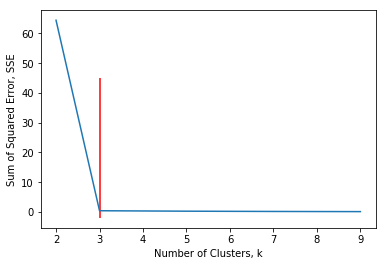

In [118]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# n_clusters is the "k" 
sse = {}
for n_cluster1 in range(2, 10):
    kmeans1 = KMeans(n_clusters = n_cluster1, max_iter = 500).fit(se_grouped_clustering)
    se_grouped_clustering["clusters"] = kmeans1.labels_
    
    # The inertia is the sum of distances of samples to their closest cluster centre
    sse[n_cluster1] = kmeans1.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters, k")
plt.ylabel("Sum of Squared Error, SSE")
# vertical line
plt.vlines(3, ymin = -2, ymax = 45, colors = 'red')
plt.show()

K = 3

### Using Silhouette Coefficient for Clustering
The highest Silhouette Coefficient gives the best match to its own cluster.

In [119]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

for n_cluster2 in range(2, 10):
    kmeans2 = KMeans(n_clusters = n_cluster2, random_state = 0).fit(se_grouped_clustering)
    label2 = kmeans2.labels_
    sil_coeff = silhouette_score(se_grouped_clustering, label2, metric = 'euclidean')
    print("Where n_clusters = {}, the Silhouette Coefficient is {}".format(n_cluster2, sil_coeff))

Where n_clusters = 2, the Silhouette Coefficient is 0.6016915211967249
Where n_clusters = 3, the Silhouette Coefficient is 0.6083491898789148
Where n_clusters = 4, the Silhouette Coefficient is 0.6842127450595982
Where n_clusters = 5, the Silhouette Coefficient is 0.6659832442474792
Where n_clusters = 6, the Silhouette Coefficient is 0.7215161053788168
Where n_clusters = 7, the Silhouette Coefficient is 0.8361562241203689
Where n_clusters = 8, the Silhouette Coefficient is 0.8556347667216337
Where n_clusters = 9, the Silhouette Coefficient is 0.9382498464101798


Higher n_clusters = higher Silhouette Coefficient
5 n_clusters will be used

In [120]:
se_clusters.columns

Index(['Location', 'Borough', 'Postcode', 'Latitude', 'Longitude',
       'Cluster Labels', '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')

### Visiualization

In [121]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(se_clusters['Latitude'], se_clusters['Longitude'], se_clusters['Location'], se_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

display(map_clusters)

In [122]:
#Cluster 1
se_clusters.loc[se_clusters['Cluster Labels'] == 0, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Croydon,0,Pub,Grocery Store,Supermarket,Café,Coffee Shop,Tram Station,Clothing Store,Platform,Park,Indian Restaurant
31,Croydon,0,Pub,Grocery Store,Supermarket,Café,Coffee Shop,Tram Station,Clothing Store,Platform,Park,Indian Restaurant


In [123]:
#Cluster 2
se_clusters.loc[se_clusters['Cluster Labels'] == 1, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Southwark,1,Café,Coffee Shop,Park,Pub,Italian Restaurant,Middle Eastern Restaurant,Cocktail Bar,Grocery Store,Indian Restaurant,Beer Bar
4,Southwark,1,Pub,Café,Pizza Place,Park,Italian Restaurant,Restaurant,Forest,Mediterranean Restaurant,Cocktail Bar,Burger Joint
13,Lambeth,1,Coffee Shop,Pub,Café,Pizza Place,Park,Market,Cocktail Bar,Brewery,Burger Joint,Indian Restaurant
24,Southwark,1,Pub,Café,Coffee Shop,Park,Pizza Place,Bar,Art Gallery,Burger Joint,Cocktail Bar,Gastropub
25,Lambeth,1,Café,Park,Pub,Coffee Shop,Hotel,Italian Restaurant,Gay Bar,Garden,Theater,Street Food Gathering
27,Southwark,1,Pub,Café,Coffee Shop,Park,Pizza Place,Bar,Art Gallery,Burger Joint,Cocktail Bar,Gastropub
38,Southwark,1,Café,Coffee Shop,Pub,Park,Italian Restaurant,Brewery,Theater,Pizza Place,Art Gallery,Hotel
41,Lambeth,1,Café,Coffee Shop,Park,Pub,Italian Restaurant,Middle Eastern Restaurant,Cocktail Bar,Grocery Store,Indian Restaurant,Beer Bar
43,Southwark,1,Café,Coffee Shop,Park,Pub,Italian Restaurant,Middle Eastern Restaurant,Cocktail Bar,Grocery Store,Indian Restaurant,Beer Bar


In [124]:
#Cluster 3
se_clusters.loc[se_clusters['Cluster Labels'] == 2, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Lewisham,2,Pub,Coffee Shop,Café,Park,Bar,Gastropub,Indian Restaurant,Italian Restaurant,Cocktail Bar,Hotel
2,Lewisham,2,Pub,Coffee Shop,Café,Bar,Park,Garden,Vietnamese Restaurant,Indie Movie Theater,Sandwich Place,Brewery
3,Southwark,2,Pub,Café,Park,Grocery Store,Coffee Shop,Bakery,Farmers Market,Brewery,Pizza Place,Gym / Fitness Center
9,Lewisham,2,Pub,Grocery Store,Coffee Shop,Café,Park,Gym / Fitness Center,Supermarket,Gastropub,Italian Restaurant,Japanese Restaurant
10,Lambeth,2,Pub,Coffee Shop,Park,Grocery Store,Café,Bakery,Italian Restaurant,Train Station,Pizza Place,Pharmacy
11,Lambeth,2,Pub,Coffee Shop,Park,Grocery Store,Café,Bakery,Italian Restaurant,Train Station,Pizza Place,Pharmacy
14,Lewisham,2,Pub,Café,Gastropub,Park,Garden,Fish & Chips Shop,Food Truck,Coffee Shop,Restaurant,Gym
15,Lewisham,2,Pub,Grocery Store,Coffee Shop,Café,Park,Gym / Fitness Center,Supermarket,Gastropub,Italian Restaurant,Japanese Restaurant
16,Lewisham,2,Pub,Coffee Shop,Café,Park,Gastropub,Bar,Food Truck,Italian Restaurant,Restaurant,Fish & Chips Shop
17,Lewisham,2,Pub,Coffee Shop,Café,Park,Gastropub,Bar,Food Truck,Italian Restaurant,Restaurant,Fish & Chips Shop


In [125]:
#Cluster 4
se_clusters.loc[se_clusters['Cluster Labels'] == 3, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Southwark,3,Café,Coffee Shop,Pub,Park,Hotel,Theater,Italian Restaurant,Street Food Gathering,Beer Bar,Scenic Lookout
6,Southwark,3,Café,Coffee Shop,Pub,Park,Hotel,Theater,Italian Restaurant,Street Food Gathering,Beer Bar,Scenic Lookout
7,Southwark,3,Café,Coffee Shop,Pub,Park,Hotel,Theater,Italian Restaurant,Street Food Gathering,Beer Bar,Scenic Lookout
8,Southwark,3,Theater,Hotel,Coffee Shop,Scenic Lookout,Pub,Grocery Store,Italian Restaurant,Cocktail Bar,Street Food Gathering,Beer Bar
18,Lambeth,3,Theater,Hotel,Coffee Shop,Scenic Lookout,Pub,Grocery Store,Italian Restaurant,Cocktail Bar,Street Food Gathering,Beer Bar
22,Southwark,3,Coffee Shop,Café,Pub,Theater,Italian Restaurant,Hotel,Park,Scenic Lookout,Beer Bar,Cocktail Bar
23,Southwark,3,Coffee Shop,Café,Pub,Theater,Italian Restaurant,Hotel,Park,Scenic Lookout,Beer Bar,Cocktail Bar
30,Southwark,3,Theater,Hotel,Coffee Shop,Scenic Lookout,Pub,Grocery Store,Italian Restaurant,Cocktail Bar,Street Food Gathering,Beer Bar


In [126]:
#Cluster 5
se_clusters.loc[se_clusters['Cluster Labels'] == 4, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Lewisham,4,Grocery Store,Pub,Park,Café,Italian Restaurant,Supermarket,Soccer Field,Coffee Shop,Train Station,Fast Food Restaurant
19,Lewisham,4,Grocery Store,Pub,Park,Café,Italian Restaurant,Supermarket,Soccer Field,Coffee Shop,Train Station,Fast Food Restaurant
26,Lewisham,4,Grocery Store,Park,Supermarket,Café,Pub,Italian Restaurant,Fast Food Restaurant,Coffee Shop,Train Station,Gas Station
32,Lewisham,4,Grocery Store,Park,Supermarket,Café,Pub,Italian Restaurant,Fast Food Restaurant,Coffee Shop,Train Station,Gas Station
44,Lewisham,4,Grocery Store,Park,Supermarket,Café,Pub,Italian Restaurant,Fast Food Restaurant,Coffee Shop,Train Station,Gas Station
45,Lewisham,4,Grocery Store,Pub,Park,Café,Italian Restaurant,Supermarket,Soccer Field,Coffee Shop,Train Station,Fast Food Restaurant


## Results

The following can be inferred from the 5 clusters above:
1. Pubs, Cafe, Coffee Shops are popular in the South East London.
2. Italian Restaurants are very popular in the South East London area. Especially in Southwark and Lambeth areas.
3. Pubs are the most common eatery.

## Discussion & Conclusion

As we can see, Italian restaurants in Southwark and Lambeth look to be very strong in this area of London. A fine dining option within this market would likely do well in these neighborhoods, or perhaps just outside of them (to account for density). 

Additional data that could help with determining optimum location would include historic crime data, pedestrian and vehicular traffic flow maps, public transit access maps, and additional calls to Foursquare.